# U-net Architecture

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Input, Concatenate, MaxPool2D, Conv2DTranspose, Add
from tensorflow.keras.models import Model

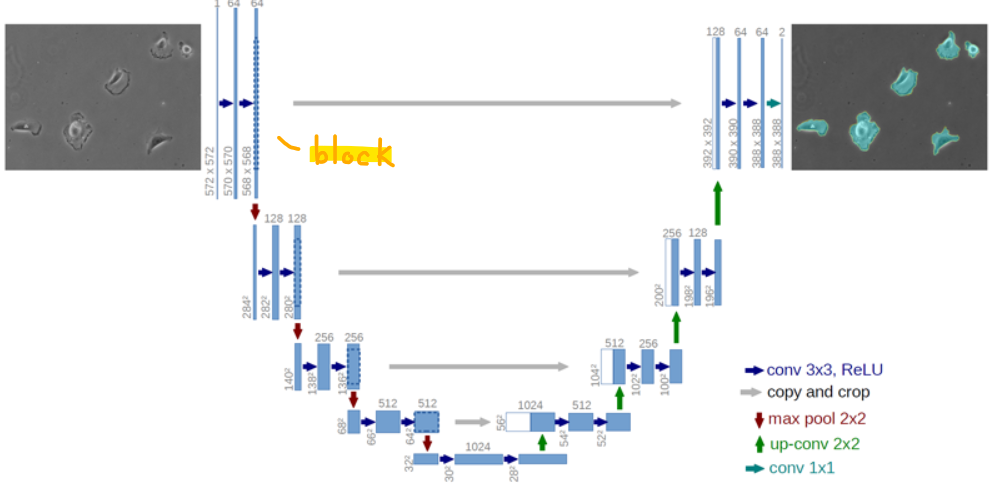

In [ ]:
def block(input, num_filters):
  x = input
  for i in range(2):
    x = Conv2D(num_filters,3,padding='same')(x) #filter 개수, kernel size
    x = BatchNormalization()(x) #정규화, 입력 계층을 정규화하여 더 빠르고 안정적으로 만듦
    x = Activation('relu')(x) #relu 활성화 함수 사용
  return x

In [ ]:
def encoder_block(input, num_filters):
    x = block(input, num_filters) #나중에 decoder부분에서 skip역할을 함
    p = MaxPool2D((2, 2))(x)
    return x, p #p는 convolution연결을 위해, x는 skip connection을 위해

In [ ]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input) #size를 2배로 늘리기 위해
    x = Concatenate()([x, skip_features]) #copy and crop 부분
    x = block(x, num_filters)
    return x
#Conv2DTranspose같은 경우 중요한 정보를 기준으로 주변부 정보를 복원하는 역할.
#결국 중요한 정보 기준으로 이미지를 재구성.
#UpSampling2D는 적은 해상도를 일부러 고해상도로 올리는것이다. 단순히 잡아 늘리는 역할.
#Conv2DTranspose는 Convolution 연산이 들어가서 해상도를 키운다. 이 연산은 당연히 학습과정에서 필터가 학습이 된다.

In [ ]:
def Unet(input_shape):
    inputs = Input(input_shape)

    #Encoder part
    s1, p1 = encoder_block(inputs, 64) 
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    #s1,2,3,4 는 decoder에서 skip connection으로 사용됨


    #Middle part
    b1 = block(p4, 1024)

    #Decoder part
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4) #이진분할이라고 가정

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
input_shape = (512, 512, 3)
model =Unet(input_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 512, 512, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 512, 512, 64) 256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 512, 512, 64) 0           batch_normalization_18[0][0]     
______________________________________________________________________________________________